# Utilities for Machine Learning
Explore utilities to extend and simplify preprocessing and training.

## Set up
We're having to set a lot of seeds for reproducibility now, so let's wrap it all up in a function.

In [1]:
import numpy as np
import pandas as pd
import random
import torch
import torch.nn as nn

In [2]:
SEED = 1234

In [3]:
def set_seeds(seed=1234):
    """Set seeds for reproducibility."""
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed) # multi-GPU

In [4]:
# Set seeds for reproducibility
set_seeds(seed=SEED)

In [5]:
# Set device
cuda = True
device = torch.device("cuda" if (
    torch.cuda.is_available() and cuda) else "cpu")
torch.set_default_tensor_type("torch.FloatTensor")
if device.type == "cuda":
    torch.set_default_tensor_type("torch.cuda.FloatTensor")
print (device)

cuda


### Load data
We'll use the same spiral dataset from previous lessons to demonstrate our utilities.

In [6]:
import matplotlib.pyplot as plt
import pandas as pd
from mlopsfd.datasets import generate_spirals

In [7]:
df = generate_spirals()
df

,X1,X2,color
0,-0.320767,0.145567,c1
1,0.029032,0.132386,c1
2,0.180597,0.206408,c1
3,0.079140,0.094877,c1
4,0.237548,0.109245,c1
...,...,...,...
495,-7.606522,2.025510,c3
496,-7.573552,1.841280,c3
497,-7.548512,2.280927,c3
498,-7.981224,1.829948,c3


In [8]:
# Data shapes
X = df[["X1", "X2"]].values
y = df["color"].values
print ("X: ", np.shape(X))
print ("y: ", np.shape(y))

X:  (1500, 2)
y:  (1500,)


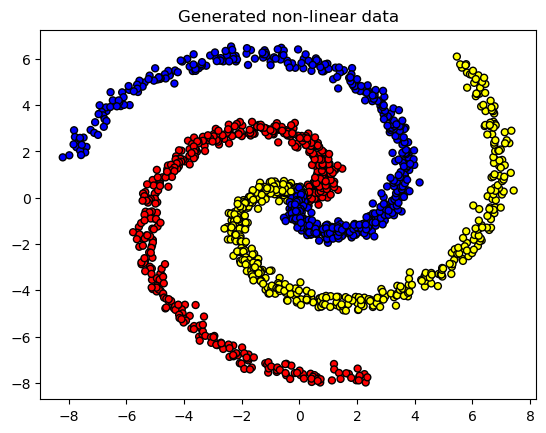

In [9]:
# Visualize data
plt.title("Generated non-linear data")
colors = {"c1": "red", "c2": "yellow", "c3": "blue"}
plt.scatter(X[:, 0], X[:, 1], c=[colors[_y] for _y in y], edgecolors="k", s=25)
plt.show()

### Split data

In [10]:
import collections
from sklearn.model_selection import train_test_split

In [11]:
TRAIN_SIZE = 0.7
VAL_SIZE = 0.15
TEST_SIZE = 0.15

In [12]:
def train_val_test_split(X, y, train_size):
    """Split dataset into data splits."""
    X_train, X_, y_train, y_ = train_test_split(X, y, train_size=TRAIN_SIZE, stratify=y)
    X_val, X_test, y_val, y_test = train_test_split(X_, y_, train_size=0.5, stratify=y_)
    return X_train, X_val, X_test, y_train, y_val, y_test

In [13]:
# Create data splits
X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(
    X=X, y=y, train_size=TRAIN_SIZE)
print (f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print (f"X_val: {X_val.shape}, y_val: {y_val.shape}")
print (f"X_test: {X_test.shape}, y_test: {y_test.shape}")
print (f"Sample point: {X_train[0]} → {y_train[0]}")

X_train: (1050, 2), y_train: (1050,)
X_val: (225, 2), y_val: (225,)
X_test: (225, 2), y_test: (225,)
Sample point: [-0.56183286  0.58527567] → c2


### Label encoding
Next we'll define a `LabelEncoder` to encode our text labels into unique indices. We're not going to use scikit-learn's LabelEncoder anymore because we want to be able to save and load our instances the way we want to.

In [14]:
import itertools

In [15]:
class LabelEncoder(object):
    """Label encoder for tag labels."""
    def __init__(self, class_to_index={}):
        self.class_to_index = class_to_index or {}  # mutable defaults ;)
        self.index_to_class = {v: k for k, v in self.class_to_index.items()}
        self.classes = list(self.class_to_index.keys())

    def __len__(self):
        return len(self.class_to_index)

    def __str__(self):
        return f"<LabelEncoder(num_classes={len(self)})>"

    def fit(self, y):
        classes = np.unique(y)
        for i, class_ in enumerate(classes):
            self.class_to_index[class_] = i
        self.index_to_class = {v: k for k, v in self.class_to_index.items()}
        self.classes = list(self.class_to_index.keys())
        return self

    def encode(self, y):
        encoded = np.zeros((len(y)), dtype=int)
        for i, item in enumerate(y):
            encoded[i] = self.class_to_index[item]
        return encoded

    def decode(self, y):
        classes = []
        for i, item in enumerate(y):
            classes.append(self.index_to_class[item])
        return classes

    def save(self, fp):
        with open(fp, "w") as fp:
            contents = {'class_to_index': self.class_to_index}
            json.dump(contents, fp, indent=4, sort_keys=False)

    @classmethod
    def load(cls, fp):
        with open(fp, "r") as fp:
            kwargs = json.load(fp=fp)
        return cls(**kwargs)

In [16]:
# Encode
label_encoder = LabelEncoder()
label_encoder.fit(y_train)
label_encoder.class_to_index

{'c1': 0, 'c2': 1, 'c3': 2}

In [17]:
# Convert labels to tokens
print (f"y_train[0]: {y_train[0]}")
y_train = label_encoder.encode(y_train)
y_val = label_encoder.encode(y_val)
y_test = label_encoder.encode(y_test)
print (f"y_train[0]: {y_train[0]}")

y_train[0]: c2
y_train[0]: 1


In [18]:
# Class weights
counts = np.bincount(y_train)
class_weights = {i: 1.0/count for i, count in enumerate(counts)}
print (f"counts: {counts}\nweights: {class_weights}")

counts: [350 350 350]
weights: {0: 0.002857142857142857, 1: 0.002857142857142857, 2: 0.002857142857142857}


### Standardize data
We need to standardize our data (zero mean and unit variance) so a specific feature's magnitude doesn't affect how the model learns its weights. We're only going to standardize the inputs X because our outputs y are class values. We're going to compose our own `StandardScaler` class so we can easily save and load it later during inference.

In [19]:
class StandardScaler(object):
    def __init__(self, mean=None, std=None):
        self.mean = np.array(mean)
        self.std = np.array(std)

    def fit(self, X):
        self.mean =  np.mean(X_train, axis=0)
        self.std = np.std(X_train, axis=0)

    def scale(self, X):
        return (X - self.mean) / self.std

    def unscale(self, X):
        return (X * self.std) + self.mean

    def save(self, fp):
        with open(fp, "w") as fp:
            contents = {"mean": self.mean.tolist(), "std": self.std.tolist()}
            json.dump(contents, fp, indent=4, sort_keys=False)

    @classmethod
    def load(cls, fp):
        with open(fp, "r") as fp:
            kwargs = json.load(fp=fp)
        return cls(**kwargs)

In [20]:
# Standardize the data (mean=0, std=1) using training data
X_scaler = StandardScaler()
X_scaler.fit(X_train)

In [21]:
# Apply scaler on training and test data (don't standardize outputs for classification)
X_train = X_scaler.scale(X_train)
X_val = X_scaler.scale(X_val)
X_test = X_scaler.scale(X_test)

In [22]:
# Check (means should be ~0 and std should be ~1)
print (f"X_test[0]: mean: {np.mean(X_test[:, 0], axis=0):.1f}, std: {np.std(X_test[:, 0], axis=0):.1f}")
print (f"X_test[1]: mean: {np.mean(X_test[:, 1], axis=0):.1f}, std: {np.std(X_test[:, 1], axis=0):.1f}")

X_test[0]: mean: -0.0, std: 1.0
X_test[1]: mean: 0.1, std: 1.0


## DataLoader
We're going to place our data into a `Dataset` and use a `DataLoader` to efficiently create batches for training and evaluation.

In [23]:
import torch

In [24]:
# Seed seed for reproducibility
torch.manual_seed(SEED)

In [29]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.y)

    def __str__(self):
        return f"<Dataset(N={len(self)})>"

    def __getitem__(self, index):
        X = self.X[index]
        y = self.y[index]
        return (X, y)

    def collate_fn(self, batch):
        """Processing on a batch."""
        # Get inputs
        X = np.stack([Xy[0] for Xy in batch], axis=0)
        y = np.array([Xy[1] for Xy in batch])

        # Cast
        X = torch.FloatTensor(X.astype(np.float32))
        y = torch.LongTensor(y.astype(np.int32))

        return X, y

    def create_dataloader(self, batch_size, shuffle=False, drop_last=False):
        return torch.utils.data.DataLoader(
            dataset=self, 
            batch_size=batch_size, 
            collate_fn=self.collate_fn,
            shuffle=shuffle, 
            drop_last=drop_last,
            pin_memory=True
        )

We don't really need the `collate_fn` here but we wanted to make it transparent because we will need it when we want to do specific processing on our batch (ex. padding).

In [30]:
# Create datasets
train_dataset = Dataset(X=X_train, y=y_train)
val_dataset = Dataset(X=X_val, y=y_val)
test_dataset = Dataset(X=X_test, y=y_test)
print ("Datasets:\n"
    f"  Train dataset:{train_dataset.__str__()}\n"
    f"  Val dataset: {val_dataset.__str__()}\n"
    f"  Test dataset: {test_dataset.__str__()}\n"
    "Sample point:\n"
    f"  X: {train_dataset[0][0]}\n"
    f"  y: {train_dataset[0][1]}")

Datasets:
  Train dataset:<Dataset(N=1050)>
  Val dataset: <Dataset(N=225)>
  Test dataset: <Dataset(N=225)>
Sample point:
  X: [-0.18217904  0.18515521]
  y: 1


So far, we used batch gradient descent to update our weights. This means that we calculated the gradients using the entire training dataset. We also could've updated our weights using stochastic gradient descent (SGD) where we pass in one training example one at a time. The current standard is **mini-batch gradient descent**, which strikes a balance between batch and SGD, where we update the weights using a mini-batch of n (`BATCH_SIZE`) samples. This is where the `DataLoader` object comes in handy.

In [31]:
train_dataset.X
train_dataset.y

array([1, 2, 0, ..., 1, 1, 1])

In [32]:
# Create dataloaders
batch_size = 64
train_dataloader = train_dataset.create_dataloader(batch_size=batch_size)
val_dataloader = val_dataset.create_dataloader(batch_size=batch_size)
test_dataloader = test_dataset.create_dataloader(batch_size=batch_size)
batch_X, batch_y = next(iter(train_dataloader))
print ("Sample batch:\n"
    f"  X: {batch_X.size()}\n"
    f"  y: {batch_y.size()}\n"
    "Sample point:\n"
    f"  X: {batch_X[0]}\n"
    f"  y: {batch_y[0]}")

[(array([-0.18217904,  0.18515521]), 1), (array([0.84728812, 1.24351873]), 2), (array([-1.50790872, -1.14169926]), 0), (array([0.84675294, 0.06555995]), 2), (array([0.04520574, 0.73408251]), 0), (array([0.27858799, 0.17267922]), 0), (array([ 2.04456022, -0.02368528]), 1), (array([1.14026227, 0.09328241]), 2), (array([1.08686124, 0.90207501]), 2), (array([1.11752167, 0.61341058]), 2), (array([-0.50881161,  0.99555642]), 0), (array([ 0.17239165, -0.46202931]), 2), (array([-0.60905511, -0.7988144 ]), 1), (array([ 0.04203647, -0.27630368]), 2), (array([0.16372892, 0.19660474]), 0), (array([0.24108459, 1.65458447]), 2), (array([-0.03403311, -0.18330752]), 2), (array([0.14913294, 0.07206349]), 0), (array([ 0.58775369, -0.37664398]), 2), (array([-0.6173156 , -0.14275312]), 1), (array([-0.35526688,  0.06179702]), 1), (array([-0.5269325 ,  0.02227635]), 1), (array([-0.2437517 ,  0.18321093]), 1), (array([-1.46798857, -0.31744311]), 0), (array([0.29928388, 0.3709331 ]), 0), (array([-1.71263917, 

- [ ] With `pin_memory=True` I cannot put it directly on the GPU through `torch.cuda.FloatTensor` during `collate_fn`
      Need to check if this is a problem. Maybe we can just convert to GPU during training.